# Constructing an HDR image

Almost all modern cameras and even phones have a magical **HDR** mode, and it produces a truly miraculous result—photos don't contain under- or overexposed areas. **HDR (High Dynamic Range)**, and you can reproduce such a result in OpenCV! This recipe tells you about HDR imaging functions and how to use them properly.

First, you need to have a set of images with different known exposure times. Modern cameras store a lot of information including exposure time in image files, so it's worth checking the image's properties. 

Computing an HDR image starts with recovering **CRF (Camera Response Function)**, which is a mapping between real intensity and the pixel's intensity (which is in the `[0, 255]` range) for each color channel. Usually it's non-linear, and makes it impossible to simply combine images with different exposures. It can be done by creating an instance of the calibrate algorithm with `cv2.createCalibrateDebevec`. When the calibration instance is created, you need to invoke its process method and pass an array of images and an array of exposure times. The process method returns CRF of our camera.

The next step is creating an HDR image. To do this, we should get an instance of the photos merging algorithm by calling `cv2.createMergeDebevec`. When the object is constructed, we need to call its `process` method and pass images, exposure times, and CRF as arguments. As a result, we get an HDR image, which can't be displayed with `imshow`, but can be saved in the `.hdr` format with `imwrite` and viewed in special tools.

Now we need to display our HDR image. To do this, we need to correctly squeeze its dynamic range to `8` bits. This process is called tonemapping. To perform this process, you need to build a tonemapping object with `cv2.createTonemapDurand` and call its `process` function.  This function accepts an HDR image and a returns floating point image.

There's also an alternative way to merge photos with different exposures. You need to create another algorithm instance with the `cv2.createMergeMertens` function. The resulting object has the `process` method, which merges our images—just pass them as an argument. The result of the function work is a merged image.

In the top row of the figure are the two original images with different exposures: the left one with a long exposure time, and the right one with a short exposure time. As a result, we can see both the desk lamp labels near the bulb and the QR code. The bottom row contains the results for two approaches from the recipe's code—in both cases, we can see all the details.

In [1]:
# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep = pYstep = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S08\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s08\env

d:\html_doc\program\opencv\packt\s08\env\lib\site-packages
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\pip-20.1b1-py3.8.egg
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S08\env


### Loading exposure images into a list

The first stage is simply loading all images into a list. In addition, we will need the exposure times for the regular HDR algorithms. Pay attention for the data types, as the images should be `1`-channel or `3`-channels `8`-bit (`np.uint8`) and the exposure times need to be `float32` and in seconds.

------  i[0] 33------------------    Shape(2304, 4096, 3) 33: uint8
[[74 39 66] [93 58 85] [96 63 90] [102  69  96] [98 69 94] [89 60 85] [59 35 59] ]
[[91 56 83] [86 51 78] [96 63 90] [116  83 110] [92 63 89] [76 47 73] [68 44 68] ]
------  i[1] 100-----------------    Shape(2304, 4096, 3) 100: uint8
[[50 24 42] [48 22 40] [58 35 50] [64 41 56] [66 45 60] [62 41 56] [59 38 53] ]
[[53 27 45] [46 20 38] [56 30 46] [53 27 43] [48 25 40] [55 32 47] [51 31 44] ]
------  i[2] 179-----------------    Shape(2304, 4096, 3) 179: uint8
[[22 18 24] [18 14 20] [14 10 16] [18 14 20] [22 16 21] [22 16 21] [24 18 23] ]
[[18 14 20] [18 14 20] [17 13 18] [19 15 20] [20 14 19] [18 12 17] [18 12 17] ]
------  i[3] 892-----------------    Shape(2304, 4096, 3) 892: uint8
[[8 2 7] [7 1 6] [7 0 3] [8 1 4] [9 2 5] [9 2 5] [8 2 3] ]
[[8 2 7] [7 1 6] [8 1 4] [8 1 4] [9 2 5] [9 2 5] [8 2 3] ]
------  i[4] 1560----------------    Shape(2304, 4096, 3) 1560: uint8
[[6 0 2] [6 0 2] [6 0 2] [6 0 2] [5 0 1] [5 0 1] [5

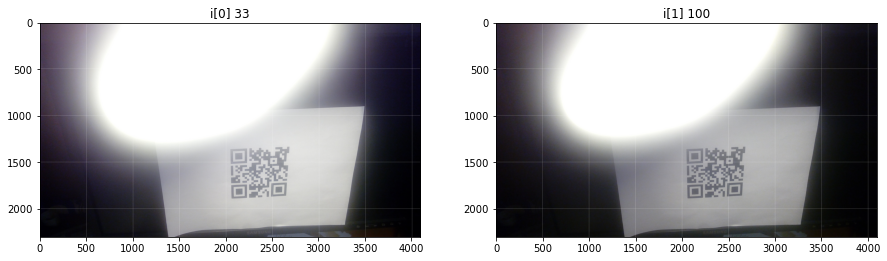

2 3


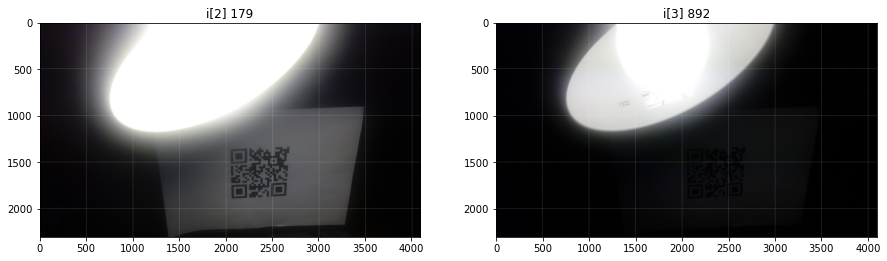

4 5


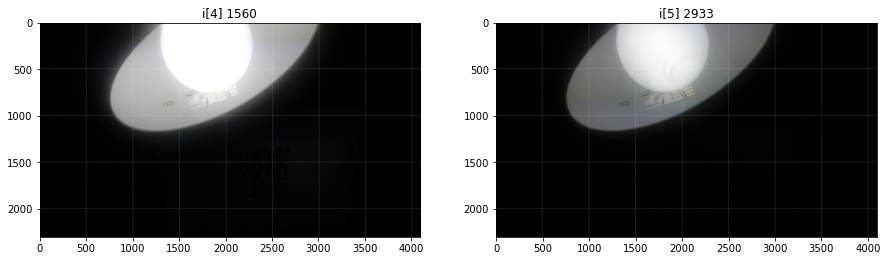

In [2]:
imgs_names = ['33', '100', '179', '892', '1560', '2933']

exp_times = []
images = []

for name in imgs_names:
    exp_times.append(1/float(name))
    images.append(cv2.imread('../data/hdr/%s.jpg' % name, cv2.IMREAD_COLOR))

exp_times = np.array(exp_times).astype(np.float32)




#######################################################
for i in range(len(images)):
    print_image('i[{0}] {1}'.format(i,imgs_names[i]),imgs_names[i],images[i],0,2,0,7)

image_frames =[]
for i in range(len(images)):
    image_frames.append(['i[{0}] {1}'.format(i,imgs_names[i]),
                         draw_grid(np.copy(images[i]),500,(255,255,255))[:,:,[2,1,0]]])

k = 2
for i in range(0,len(image_frames),k):
    print(i,i+k-1)
    plt_view_image(plt,image_frames[i:i+k], figsize=(15,8), axis='on', cmap='gray')

### Obtain Camera Response Function (CRF):

### 1) First method is Debevec

------  createCalibrateDebevec---    Shape(256, 1, 3) responseDebevec: float32
[[0.0109626  0.01025006 0.01039248] ]
[[0.01441088 0.01853125 0.01812095] ]
[[0.01796694 0.03119521 0.02942917] ]
[[0.02250972 0.04481338 0.04098551] ]
[[0.03029365 0.05717418 0.05166496] ]
[[0.04036354 0.06783992 0.06081356] ]
[[0.05206131 0.07676753 0.06835885] ]


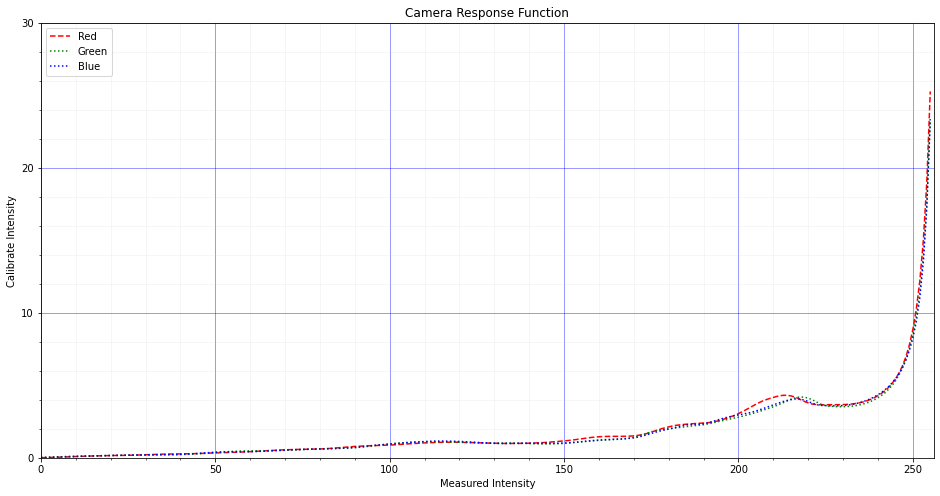

In [3]:
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(np.copy(images), exp_times.copy())


#######################################################
print_image('createCalibrateDebevec','responseDebevec',responseDebevec,0,7,0,7)

plt.figure(figsize=(16,8))
plt_view_grid(plt, 'on',(0,256,0,30),(50,10,10,2),major_color='b')
plt.plot(range(256),responseDebevec[:,:,0],'--r',label='Red')
plt.plot(range(256),responseDebevec[:,:,1],':g',label='Green')
plt.plot(range(256),responseDebevec[:,:,2],':b',label='Blue')
plt.xlabel('Measured Intensity');
plt.ylabel('Calibrate Intensity');
plt.title('Camera Response Function');
plt.legend(loc='upper left')
plt.show()

### Compute an HDR image:

------  createMergeDebevec-------    Shape(2304, 4096, 3) hdr_Debevec: float32
[[28.012653 12.786808 23.411266] [30.903341 16.618347 24.636873] [33.05451  17.221888 28.827106] ]
[[31.940783 17.425434 26.276026] [28.367676 14.652421 23.550367] [32.86692  17.709604 27.56452 ] ]
[[39.207783 22.520227 33.545364] [31.048313 13.239278 28.199095] [26.692822 11.974737 20.981577] ]
[[36.935074 18.622509 32.912292] [33.057415 15.002583 29.204723] [33.261654 15.444728 28.145266] ]
[[29.96058  14.66823  26.749235] [32.230316 16.028866 28.236393] [27.65546  12.782836 23.979715] ]
------  np.uint8(hdr_Debevec)----    Shape(2304, 4096, 3) np.uint8(hdr_Debevec): uint8
[[28 12 23] [30 16 24] [33 17 28] [36 19 33] [36 20 32] [33 19 29] [26 14 25] ]
[[31 17 26] [28 14 23] [32 17 27] [36 20 34] [30 17 25] [28 14 25] [26 13 22] ]
[[39 22 33] [31 13 28] [26 11 20] [35 18 28] [31 14 27] [29 16 25] [26 14 22] ]
[[36 18 32] [33 15 29] [33 15 28] [35 18 30] [32 16 28] [32 18 26] [31 18 26] ]
[[29 14 26] [32 16 

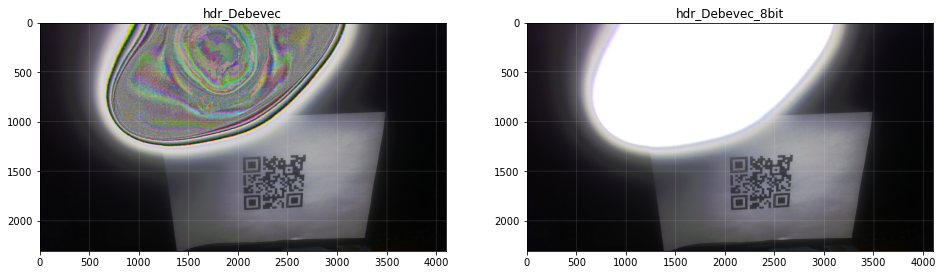

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


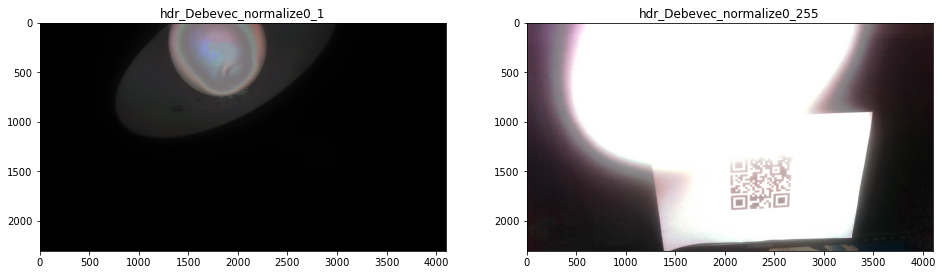

In [4]:
merge_debevec = cv2.createMergeDebevec()
hdr_Debevec = merge_debevec.process(np.copy(images), exp_times.copy(), responseDebevec)

# Convert datatype to 8-bit and save
hdr_Debevec_8bit = np.clip(hdr_Debevec, 0, 255).astype('uint8')



#######################################################
print_image('createMergeDebevec','hdr_Debevec',hdr_Debevec,0,5,0,3)
print_image('np.uint8(hdr_Debevec)','np.uint8(hdr_Debevec)',np.uint8(hdr_Debevec),0,5,0,7)
print_image('np.clip(hdr_Debevec, 0, 255)','hdr_Debevec_8bit',hdr_Debevec_8bit,0,5,0,7)

hdr_Debevec_normalize0_1 = cv2.normalize(hdr_Debevec, None, 0, 1, cv2.NORM_MINMAX)
print_image('cv2.normalize(.. 0, 1)','hdr_normalize0_1',hdr_Debevec_normalize0_1,0,5,0,3)
hdr_Debevec_normalize0_255 = cv2.normalize(hdr_Debevec, None, 0, 255, cv2.NORM_MINMAX)
print_image('cv2.normalize(.. 0, 255)','hdr_normalize0_255',hdr_Debevec_normalize0_255,0,5,0,3)


plt_view_image(plt,[["hdr_Debevec", draw_grid(np.copy(np.uint8(hdr_Debevec)),500,(255,255,255))[:,:,[2,1,0]]],
                    ["hdr_Debevec_8bit", draw_grid(np.copy(hdr_Debevec_8bit),500,(255,255,255))[:,:,[2,1,0]]]],
               figsize=(16,8), axis='on', cmap='gray')
plt_view_image(plt,[["hdr_Debevec_normalize0_1", hdr_Debevec_normalize0_1],
                    ["hdr_Debevec_normalize0_255", hdr_Debevec_normalize0_255]
                   ],
               figsize=(16,8), axis='on', cmap='gray')

### 2) Second method is Robertson

In [5]:
calibrateRobertson = cv2.createCalibrateRobertson()
responseRobertson = calibrateRobertson.process(np.copy(images), exp_times.copy())



#######################################################
print_image('createCalibrateRobertson','responseRobertson',responseRobertson,0,3,0,7)

------  createCalibrateRobertson-    Shape(256, 1, 3) responseRobertson: float32
[[nan nan nan] ]
[[nan nan nan] ]
[[nan nan nan] ]


------  createMergeRobertson-----    Shape(2304, 4096, 3) hdr_Robertson: float32
[[20.028791 10.561342 17.735823] [24.35791   15.0044155 22.140034 ] [25.55002  16.593575 23.710175] ]
[[24.099646 14.624656 21.8248  ] [22.581656 13.21963  20.361689] [25.441624 16.420918 23.551815] ]
[[26.805597 16.695581 24.576277] [21.83615  11.870463 19.709002] [18.60816   9.399226 16.376438] ]
[[27.023602 16.994919 25.03824 ] [23.077965 13.107143 20.929512] [23.04405  13.408725 20.538397] ]
[[23.252195 13.088653 21.527264] [24.151121 13.951223 22.397827] [21.131742 11.280897 18.996153] ]
------  np.uint8(hdr_Robertson)--    Shape(2304, 4096, 3) np.uint8(hdr_Robertson): uint8
[[20 10 17] [24 15 22] [25 16 23] [27 18 25] [26 18 25] [24 16 22] [18 11 17] ]
[[24 14 21] [22 13 20] [25 16 23] [30 21 28] [24 16 23] [20 12 19] [18 12 18] ]
[[26 16 24] [21 11 19] [18  9 16] [24 15 22] [22 13 20] [22 14 21] [19 11 17] ]
[[27 16 25] [23 13 20] [23 13 20] [24 14 21] [22 14 21] [24 16 23] [24 16 22] ]
[[23 13 21] 

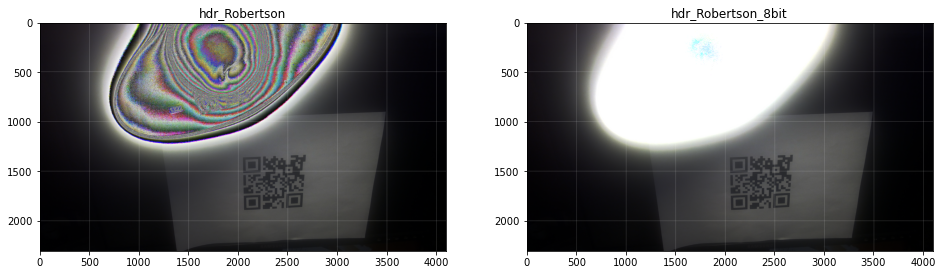

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


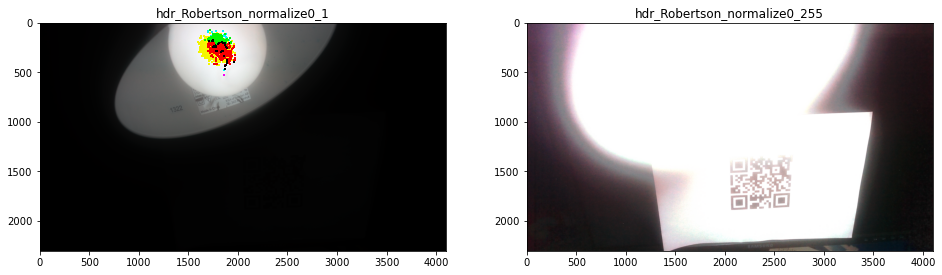

In [6]:
merge_robertson = cv2.createMergeRobertson()
hdr_Robertson = merge_robertson.process(np.copy(images), exp_times.copy())

hdr_Robertson_8bit = np.clip(hdr_Robertson, 0, 255).astype('uint8')



#######################################################
print_image('createMergeRobertson','hdr_Robertson',hdr_Robertson,0,5,0,3)
print_image('np.uint8(hdr_Robertson)','np.uint8(hdr_Robertson)',np.uint8(hdr_Robertson),0,5,0,7)
print_image('np.clip(hdr_Robertson, 0, 255)','hdr_Robertson_8bit',hdr_Robertson_8bit,0,5,0,7)


hdr_Robertson_normalize0_1 = cv2.normalize(hdr_Robertson, None, 0, 1, cv2.NORM_MINMAX)
print_image('cv2.normalize(.. 0, 1)','hdr_Robertson_normalize0_1',hdr_Robertson_normalize0_1,0,5,0,3)
hdr_Robertson_normalize0_255 = cv2.normalize(hdr_Debevec, None, 0, 255, cv2.NORM_MINMAX)
print_image('cv2.normalize(.. 0, 255)','hdr_Robertson_normalize0_255',hdr_Robertson_normalize0_255,0,5,0,3)


plt_view_image(plt,[["hdr_Robertson", draw_grid(np.copy(np.uint8(hdr_Robertson)),500,(255,255,255))[:,:,[2,1,0]]],
                    ["hdr_Robertson_8bit", draw_grid(np.copy(hdr_Robertson_8bit),500,(255,255,255))[:,:,[2,1,0]]]
                   ],
               figsize=(16,8), axis='on', cmap='gray')
plt_view_image(plt,[["hdr_Robertson_normalize0_1", hdr_Robertson_normalize0_1],
                    ["hdr_Robertson_normalize0_255", hdr_Robertson_normalize0_255]
                   ],
               figsize=(16,8), axis='on', cmap='gray')

### 3) Merge exposures using Mertens fusion

------  createMergeMertens-------    Shape(2304, 4096, 3) hdr_Mertens: float32
[[20.028791 10.561342 17.735823] [24.35791   15.0044155 22.140034 ] [25.55002  16.593575 23.710175] ]
[[24.099646 14.624656 21.8248  ] [22.581656 13.21963  20.361689] [25.441624 16.420918 23.551815] ]
[[26.805597 16.695581 24.576277] [21.83615  11.870463 19.709002] [18.60816   9.399226 16.376438] ]
[[27.023602 16.994919 25.03824 ] [23.077965 13.107143 20.929512] [23.04405  13.408725 20.538397] ]
[[23.252195 13.088653 21.527264] [24.151121 13.951223 22.397827] [21.131742 11.280897 18.996153] ]
------  np.uint8(hdr_Mertens)----    Shape(2304, 4096, 3) np.uint8(hdr_Mertens): uint8
[[20 10 17] [24 15 22] [25 16 23] [27 18 25] [26 18 25] [24 16 22] [18 11 17] ]
[[24 14 21] [22 13 20] [25 16 23] [30 21 28] [24 16 23] [20 12 19] [18 12 18] ]
[[26 16 24] [21 11 19] [18  9 16] [24 15 22] [22 13 20] [22 14 21] [19 11 17] ]
[[27 16 25] [23 13 20] [23 13 20] [24 14 21] [22 14 21] [24 16 23] [24 16 22] ]
[[23 13 21] [24 

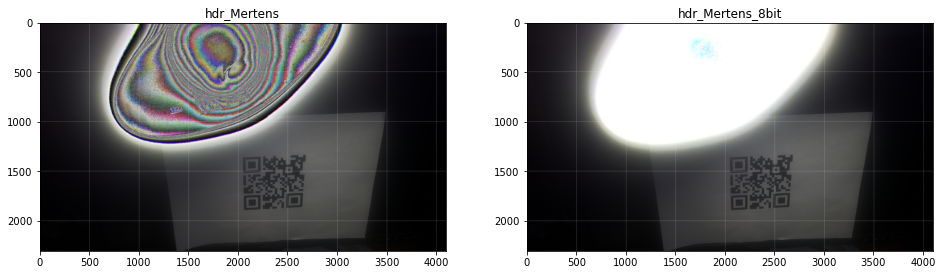

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


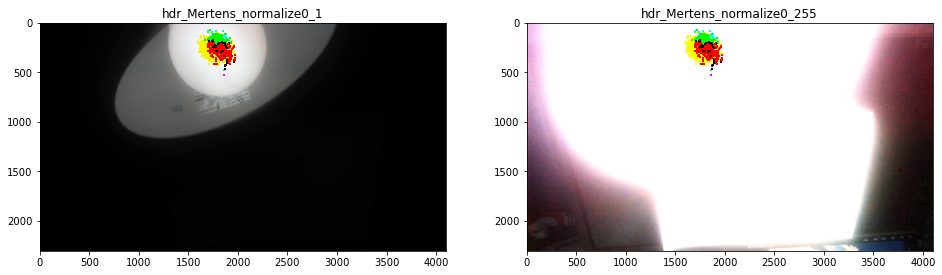

In [7]:
merge_mertens = cv2.createMergeMertens()
hdr_Mertens = merge_robertson.process(np.copy(images), exp_times.copy())

hdr_Mertens_8bit = np.clip(hdr_Mertens, 0, 255).astype('uint8')



#######################################################
print_image('createMergeMertens','hdr_Mertens',hdr_Mertens,0,5,0,3)
print_image('np.uint8(hdr_Mertens)','np.uint8(hdr_Mertens)',np.uint8(hdr_Mertens),0,5,0,7)
print_image('np.clip(hdr_Mertens, 0, 255)','hdr_Mertens_8bit',hdr_Mertens_8bit,0,5,0,7)


hdr_Mertens_normalize0_1 = cv2.normalize(hdr_Mertens, None, 0, 1, cv2.NORM_MINMAX)
print_image('cv2.normalize(.. 0, 1)','hdr_Mertens_normalize0_1',hdr_Mertens_normalize0_1,0,5,0,3)
hdr_Mertens_normalize0_255 = cv2.normalize(hdr_Mertens, None, 0, 255, cv2.NORM_MINMAX)
print_image('cv2.normalize(.. 0, 255)','hdr_Mertens_normalize0_255',hdr_Mertens_normalize0_255,0,5,0,3)


plt_view_image(plt,[["hdr_Mertens", draw_grid(np.copy(np.uint8(hdr_Mertens)),500,(255,255,255))[:,:,[2,1,0]]],
                    ["hdr_Mertens_8bit", draw_grid(np.copy(hdr_Mertens_8bit),500,(255,255,255))[:,:,[2,1,0]]]
                   ],
               figsize=(16,8), axis='on', cmap='gray')
plt_view_image(plt,[["hdr_Mertens_normalize0_1", hdr_Mertens_normalize0_1],
                    ["hdr_Mertens_normalize0_255", hdr_Mertens_normalize0_255]
                   ],
               figsize=(16,8), axis='on', cmap='gray')

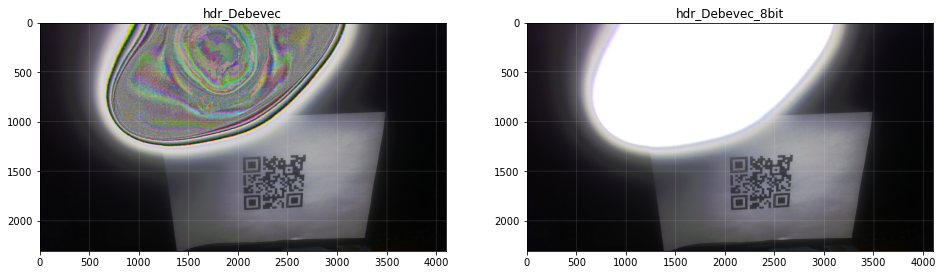

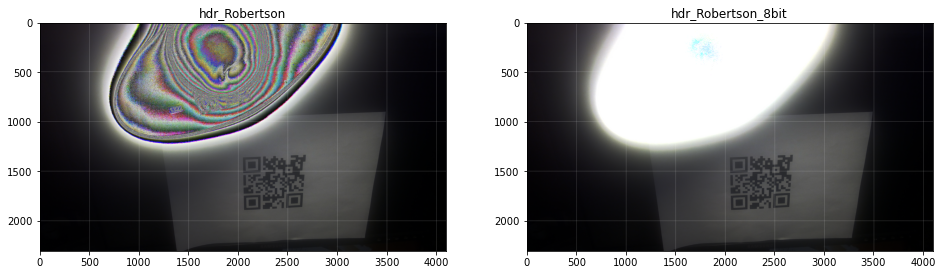

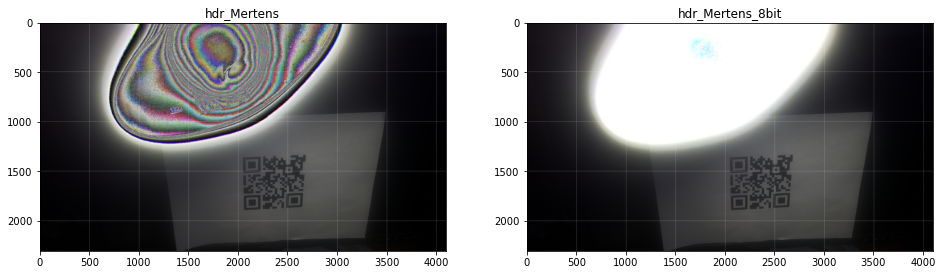

In [8]:
plt_view_image(plt,[["hdr_Debevec", draw_grid(np.copy(np.uint8(hdr_Debevec)),500,(255,255,255))[:,:,[2,1,0]]],
                    ["hdr_Debevec_8bit", draw_grid(np.copy(hdr_Debevec_8bit),500,(255,255,255))[:,:,[2,1,0]]]],
               figsize=(16,8), axis='on', cmap='gray')

plt_view_image(plt,[["hdr_Robertson", draw_grid(np.copy(np.uint8(hdr_Robertson)),500,(255,255,255))[:,:,[2,1,0]]],
                    ["hdr_Robertson_8bit", draw_grid(np.copy(hdr_Robertson_8bit),500,(255,255,255))[:,:,[2,1,0]]]
                   ],
               figsize=(16,8), axis='on', cmap='gray')

plt_view_image(plt,[["hdr_Mertens", draw_grid(np.copy(np.uint8(hdr_Mertens)),500,(255,255,255))[:,:,[2,1,0]]],
                    ["hdr_Mertens_8bit", draw_grid(np.copy(hdr_Mertens_8bit),500,(255,255,255))[:,:,[2,1,0]]]
                   ],
               figsize=(16,8), axis='on', cmap='gray')

### Turn the HDR image into a Low Dynamic Range (LDR) image to be able to display it:

In [9]:
#https://github.com/opencv/opencv/issues/14468
# Moved into opencv_contrib under NONFREE build flag.
tonemap = cv2.createTonemapDurand(2.4)
ldr = tonemap.process(hdr)

ldr = cv2.normalize(ldr, None, 0, 1, cv2.NORM_MINMAX)

cv2.imshow('ldr', ldr)
cv2.waitKey()
cv2.destroyAllWindows()

AttributeError: module 'cv2.cv2' has no attribute 'createTonemapDurand'